In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from feature_selector import FeatureSelector
import seaborn as sns
from functools import reduce

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
ice_df_dic = {}
ym_df_dic = {}

In [3]:
ice_files = os.listdir('冰鉴数据')
for f in ice_files:
    da = f.split('.')[0]
    if 'csv' in f:
        ice_df_dic[da] = pd.read_csv('冰鉴数据//'+f)
    else:
        ice_df_dic[da] = pd.read_excel('冰鉴数据//'+f)
        
ym_files  = os.listdir('友盟数据')
for f in ym_files:
    da = f.split('.')[0]
    if 'csv' in f:
        ym_df_dic[da] = pd.read_csv('友盟数据//'+f)
    else:
        ym_df_dic[da] = pd.read_excel('友盟数据//'+f)

In [4]:
main_df = ice_df_dic['新网20000_deal'][['cert_no(md5)','mobile_no(md5)','target']]
main_df.columns=['身份证号','mobile_no(md5)','target']

In [5]:
main_df.head()

,身份证号,mobile_no(md5),target
0,f50fafcdb7d8d7c6771399228091c71f,5d1d4ac4e65c914b7d888c4cc56eaf97,0
1,e71d76684c84206301d99f17c71fd086,c280b46b0d96d717c062865c54bebd15,0
2,7859be72872ea4f7fea51ab081765604,e138682ee6c948529346fd95406a8092,1
3,8a261cb31703ff1c775d082cbd5cb328,e22b2673c52adeab792aa85cbb756a5f,0
4,fa32f2b9f0154c7b7fd59cbb1423aeb2,e8fc63cceb5a5ef00f544b6a59d0f791,0


## 通用函数

In [6]:
def check_dataset(medf,tag):
    fs = FeatureSelector(medf,labels=tag)
    fs.identify_missing(0.8)
    fs.identify_single_unique()
    return fs.ops['missing'],fs.ops['single_unique']

def datastatus_summary(medf,split_col):
    label = medf['target']
    medf = medf.loc[:,split_col:]
    medf_ratio = medf.count()/medf.shape[0]
    medf_sum = pd.DataFrame(medf_ratio.round(2),columns=['匹配率'])
    medf_sum['是否纳入'] = 'Y'
    medf_sum['原因'] = np.nan
    medf_sum.loc[medf_sum['匹配率']<0.5,'是否纳入'] = 'N'
    medf_sum.loc[medf_sum['匹配率']<0.5,'原因'] = '匹配率低于50%'
    rov_feas_missing,rov_feas_unique = check_dataset(medf,label)
    medf_sum.loc[rov_feas_missing,['是否纳入','原因']] = ['N','缺失率大于80%']
    medf_sum.loc[rov_feas_unique,['是否纳入','原因']] = ['N','单一值']
    return medf_sum

def check_score_disr(score_df,y='target'):
    distr_dic = {'distr_df':[],'distr_fig':[]}
    label = score_df[y]
    score_df = pd.concat([score_df.drop(y,axis=1),label],axis=1)
    for c in score_df.columns[:-1]:
        bin_df = score_df.groupby(c)['target'].value_counts().unstack()\
                      .rename(columns={0:'good',1:'bad'})\
                      .assign(total = lambda x:x['bad']+x['good'],
                              BadRate = lambda x:x['bad']/x['bad'].sum(),
                              DistrBad= lambda x:x['bad']/x['total'],
                              DistrGood = lambda x:x['bad']/x['total']
                             )
        f = plt.figure()
        bin_df['BadRate'].plot(figsize=(10,5),title=c)
        distr_dic['distr_df'].append(bin_df)
        distr_dic['distr_fig'].append(f)
    return distr_dic

left_merge = lambda x,y:x.merge(y,how='left')

# 一、数据匹配

<!-- |表名|匹配情况|
|----|----|
|皓月|80%| -->

## 1.1 合并新网与冰鉴数据

In [7]:
icmerge = [main_df]
icmerge.extend(list(ice_df_dic.values())[1:4])
ice_merge_df = reduce(left_merge,icmerge)

## 1.2 合并新网与友盟数据

In [8]:
ym_merge_df = ym_df_dic['data_deal'].merge(ym_df_dic['result_1'])[['cert_no(md5)','type','score_1','score_2','score_3','score_4']]
ym_merge_df.rename(columns={'cert_no(md5)':'身份证号'},inplace=True)

In [9]:
all_join = ice_merge_df.merge(ym_df_dic['result_1'],how='left')

## 1.3 查看字段缺失、匹配、单一值情况

In [10]:
datasumm = datastatus_summary(all_join,'皓月分标准版')

8 features with greater than 0.80 missing values.

16 features with a single unique value.



## 1.4 查看评分识别客户能力

In [11]:
score_summary = all_join.loc[:,all_join.columns.str.contains('皓月分|星宇分|target')]
score_summary = pd.concat([score_summary['target'],score_summary.iloc[:,1:].agg(lambda x:pd.qcut(x,10))],axis=1)

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


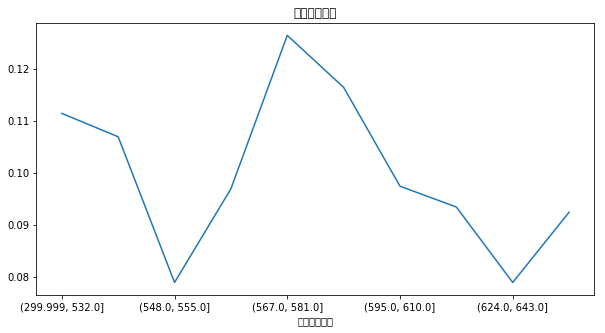

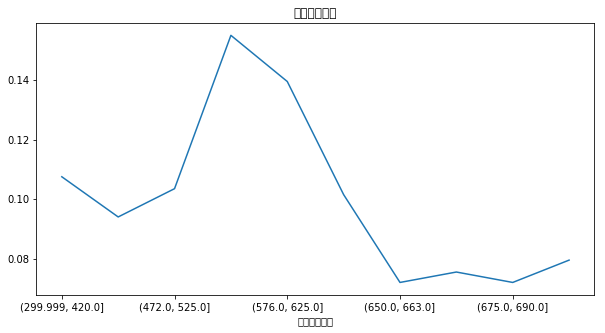

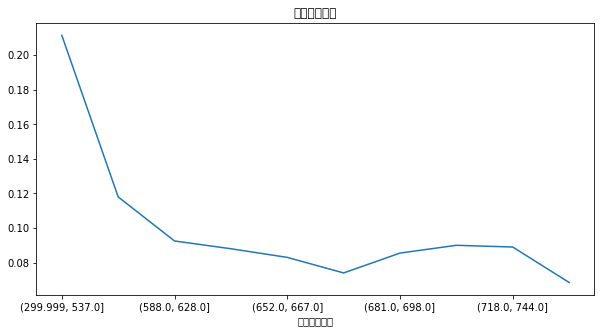

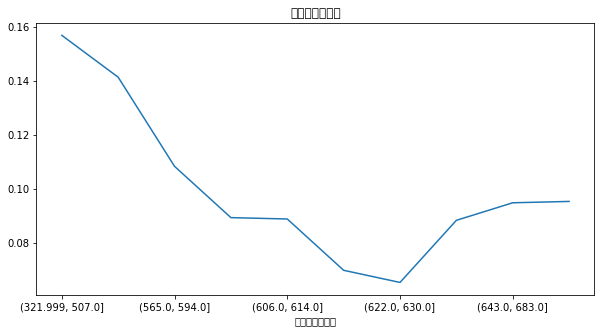

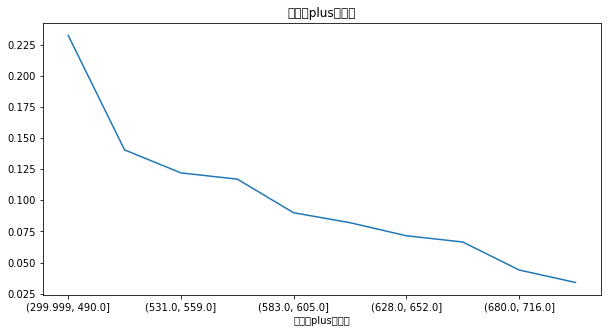

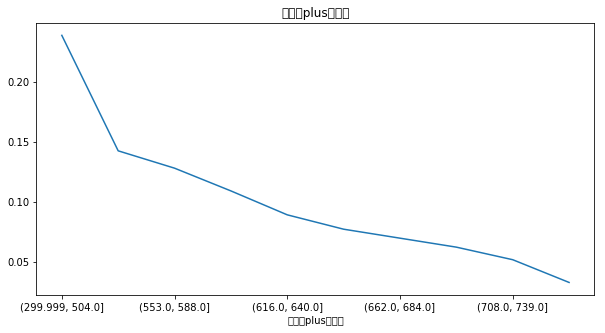

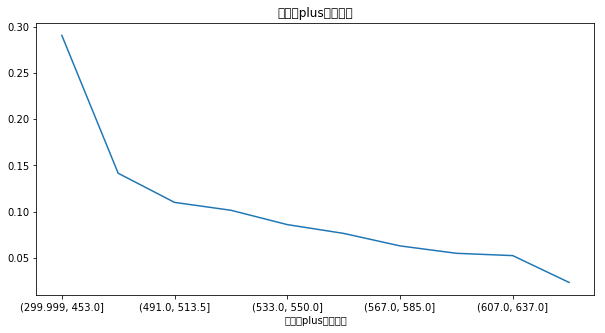

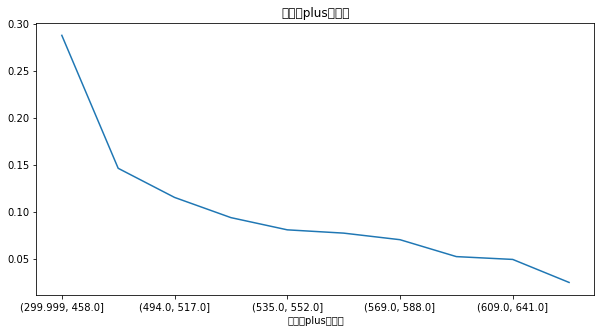

In [12]:
score_distr_dic = check_score_disr(score_summary,y='target')

In [13]:
score_summary

,target,皓月分标准版,皓月分小额版,皓月分消金版,皓月分信用卡版,星宇分plus大额版,星宇分plus标准版,星宇分plus信用卡版,星宇分plus银行版
0,0,"(567.0, 581.0]","(675.0, 690.0]","(299.999, 537.0]","(507.0, 565.0]","(605.0, 628.0]","(553.0, 588.0]","(491.0, 513.5]","(458.0, 494.0]"
1,0,"(532.0, 548.0]","(576.0, 625.0]","(698.0, 718.0]","(507.0, 565.0]","(531.0, 559.0]","(299.999, 504.0]","(453.0, 491.0]","(458.0, 494.0]"
2,1,"(532.0, 548.0]","(525.0, 576.0]","(718.0, 744.0]","(643.0, 683.0]","(605.0, 628.0]","(640.0, 662.0]","(550.0, 567.0]","(535.0, 552.0]"
3,0,"(595.0, 610.0]","(690.0, 850.0]","(299.999, 537.0]","(321.999, 507.0]","(299.999, 490.0]","(504.0, 553.0]","(299.999, 453.0]","(299.999, 458.0]"
4,0,"(299.999, 532.0]","(472.0, 525.0]","(718.0, 744.0]","(321.999, 507.0]","(583.0, 605.0]","(616.0, 640.0]","(533.0, 550.0]","(535.0, 552.0]"
...,...,...,...,...,...,...,...,...,...
20002,0,"(595.0, 610.0]","(472.0, 525.0]","(681.0, 698.0]","(614.0, 622.0]","(559.0, 583.0]","(588.0, 616.0]","(513.5, 533.0]","(517.0, 535.0]"
20003,0,"(299.999, 532.0]","(625.0, 650.0]","(698.0, 718.0]","(321.999, 507.0]","(559.0, 583.0]","(588.0, 616.0]","(550.0, 567.0]","(552.0, 569.0]"
20004,0,"(610.0, 624.0]","(650.0, 663.0]","(652.0, 667.0]","(614.0, 622.0]","(559.0, 583.0]","(616.0, 640.0]","(567.0, 585.0]","(569.0, 588.0]"
20005,0,"(532.0, 548.0]","(525.0, 576.0]","(718.0, 744.0]","(643.0, 683.0]","(628.0, 652.0]","(616.0, 640.0]","(533.0, 550.0]","(517.0, 535.0]"


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


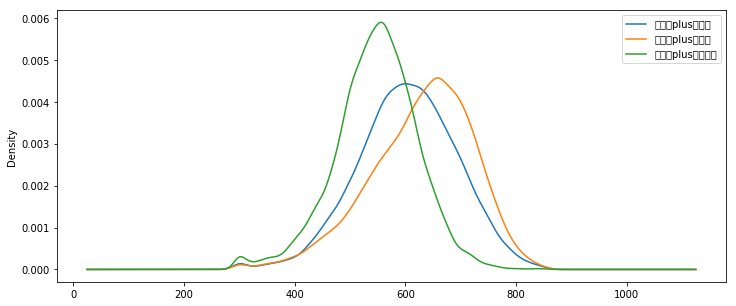

In [23]:
all_join[['星宇分plus大额版','星宇分plus标准版','星宇分plus信用卡版']].plot.kde(use_index=False,figsize=(12,5))

In [ ]:
#  多个distplot,sns测试
from sklearn.datasets import load_iris

iris = load_iris()
iris = pd.DataFrame(data=np.c_[iris['data'], iris['target']], 
                    columns=iris['feature_names'] + ['target'])

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


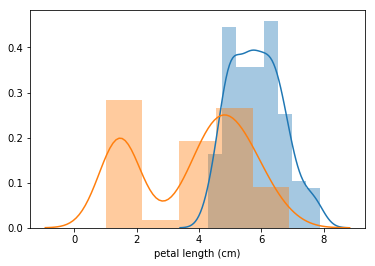

In [65]:
list(map(sns.distplot, [iris['sepal length (cm)'],iris['petal length (cm)']]))

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


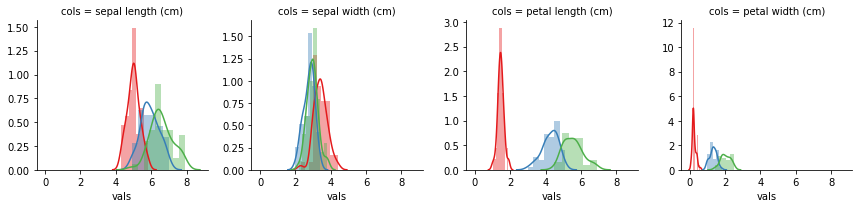

In [71]:
df = iris.melt(['target'], var_name='cols',  value_name='vals')
g = sns.FacetGrid(df, col='cols', hue="target", palette="Set1",sharey=False)
g = (g.map(sns.distplot, "vals"))

In [ ]:
datasumm['数据来源'] = np.nan
datasumm.loc['皓月分标准版':'最近一次APP使用时间距今时长','数据来源'] = '皓月'
datasumm.loc['最近一次APP使用时间距今时长':'星宇分plus大额版','数据来源'] = '探查'
datasumm.loc['星宇分plus大额版':'星宇分plus银行版','数据来源'] = '星宇'
datasumm.loc['回溯日期1':,'数据来源'] = '友盟'

In [ ]:
datasumm[datasumm['是否纳入']=='N']

In [ ]:
datasumm.to_excel('新网好e贷与友盟和冰鉴匹配分析.xlsx')